In [1]:
# ПЛАН
# 1. Загрузить размеченные данные из COCO в формате json
# 2. Вырезать объекты по bb из каждой аннотации, сохранить в папку
# 3. Взять какой-то процент данных для обучения, остальное для теста

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil
import cv2
import json

In [3]:
def display_images_side_by_side(images, titles=None, max_images_per_row=4):
    %matplotlib inline
    num_images = len(images)
    
    if num_images == 0:
        print("Нет изображений для отображения.")
        return
    
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # округление вверх
    num_cols = min(num_images, max_images_per_row)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = np.array([[ax] for ax in axes])
    
    axes = axes.reshape(num_rows, num_cols)
    
    for i, (ax, image) in enumerate(zip(axes.flat, images)):
        if image.ndim == 2:  # grayscale image
            ax.imshow(image, cmap='gray')
        else:  # RGB image
            ax.imshow(image)
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
    
    # Удаление лишних осей
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[j])
    
    plt.tight_layout()
    plt.show()

In [4]:
# где модель
instance_segmentation_model_file_name = "detectron2_COCO-InstanceSegmentation_mask_rcnn_R_50_FPN_3x_100_samples.pth"
instance_segmentation_model_file_path = Path("../models") / instance_segmentation_model_file_name
instance_segmentation_model_file_path.exists()

True

In [5]:
# где данные

data_path = Path("/Volumes/Black/Data/")
experiment = "exp20240321"
exp_path = data_path / experiment
cams = ["CAM_1_3", "CAM_2_3", "CAM_3_3", "CAM_4_3"]

def get_coco_file_path(cam):
    return exp_path / f"detectron2_COCO-InstanceSegmentation_mask_rcnn_R_50_FPN_3x_100_samples_TRACKING_{cam}.json"

def load_coco_json(coco_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

In [6]:
# Подсчет количества объектов в датасете и на скольких изображениях они встречаются
def calculate_objects_appearance_in_dataset(coco_data):
    objects = {}
    for annotation in coco_data['annotations']:
        if annotation['id'] not in objects:
            objects[annotation['id']] = 1
        else:
            objects[annotation['id']] += 1
    return objects


def get_objects_ids_by_appearance(coco_data, min_appearance, verbose=False):
    objects = calculate_objects_appearance_in_dataset(coco_data)
    images_num = len(coco_data['images'])
    
    if verbose:
        for object_id, appearance in objects.items():
            print(f"Object {object_id} appears {appearance} times")

    objects_ids = []
    for obj_id, appearance in objects.items():
        if appearance/images_num*100 >= min_appearance:
            objects_ids.append(obj_id)
    return objects_ids

In [7]:
# допустим всего где-то 4000 изображений
# на каждом по 5 объектов
# я хочу разметить 200
# значит мне нужно 40 изображений 
# значит из каждого камеры мне нужно взять 10 изображений
images_in_camera = 10

def get_linspace_from_list(lst, n):
    '''
    NB:
    при n=1 возвращает первый элемент,
    при n=2 - первый и последний элементы
    '''
    idx = np.linspace(0, len(lst)-1, n, dtype=int)
    return [lst[i] for i in idx]

In [11]:
from datetime import datetime

def is_valid_date(date_string):
    try:
        # Попробуем преобразовать строку в дату
        datetime.strptime(date_string, '%Y-%m-%d')
        return True
    except ValueError:
        # Если произошла ошибка, значит строка не является датой
        return False    

def encode_file_name(experiment, camera, datetime, object_id, extension="png"):
    file_name = f"{experiment}_{camera}_{datetime}_{object_id}.{extension}"
    return file_name

def decode_file_name(file_name):
    parts = file_name.split("_")
    experiment = parts[0]
    camera = parts[1]
    datetime = parts[2]
    object_id = parts[3]
    return experiment, camera, datetime, object_id

def get_date_and_time_from_image_path(image_path):
    date = image_path.split("/")[-1][:10]
    assert is_valid_date(date), f"Неверный формат даты: {date}"
    time = image_path.split("/")[-1][11:19]
    return date, time

file_name = "CAM_1_3/2024-03-22/original/2024-03-22_00-02-51.png"

('2024-03-22', '00-02-51')

In [66]:
# Вырезание объектов по bb из каждой аннотации, сохранение в папку
for cam in cams:
    coco_data = load_coco_json(get_coco_file_path(cam))
    objects_ids = get_objects_ids_by_appearance(coco_data, 80)
    images_data = get_linspace_from_list(coco_data['images'], images_in_camera)
    for image_data in images_data:
        image_path = exp_path / image_data["file_name"]
        image = cv2.imread(str(image_path))
        plant_images = []
        for annotation in coco_data["annotations"]:
            if annotation["image_id"] == image_data["id"] and annotation["id"] in objects_ids:
                    crop = image_data["crop_coords"]
                    bbox = annotation["bbox"]
                    cropped = image[crop[1]:crop[3], crop[0]:crop[2]]
                    object = cropped[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
                    print(image_data["file_name"])
                    # file_name = encode_file_name(experiment, cam, image_data["datetime"], annotation["id"])
                    # print(file_name)
                    raise KeyboardInterrupt
                    plant_images.append(object)    
        print(image_path)
        display_images_side_by_side(plant_images)
    break

CAM_1_3/2024-03-22/original/2024-03-22_00-02-51.png


KeyboardInterrupt: 

In [ ]:

output_coco_file_path = os.path.join(exp_path, f"{model_name}_TRACKING_{camera}.json")

In [2]:
from datetime import datetime, timedelta

def is_valid_date(date_string):
    try:
        # Попробуем преобразовать строку в дату
        datetime.strptime(date_string, '%Y-%m-%d')
        return True
    except ValueError:
        # Если произошла ошибка, значит строка не является датой
        return False 

In [3]:
def display_images_side_by_side(images, titles=None, max_images_per_row=4):
    num_images = len(images)
    
    if num_images == 0:
        print("Нет изображений для отображения.")
        return
    
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # округление вверх
    num_cols = min(num_images, max_images_per_row)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = np.array([[ax] for ax in axes])
    
    axes = axes.reshape(num_rows, num_cols)
    
    for i, (ax, image) in enumerate(zip(axes.flat, images)):
        if image.ndim == 2:  # grayscale image
            ax.imshow(image, cmap='gray')
        else:  # RGB image
            ax.imshow(image)
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
    
    # Удаление лишних осей
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[j])
    
    plt.tight_layout()
    plt.show()

In [4]:
def randomize_crop_coords(x1, y1, x2, y2, num = 20):
    x1 += np.random.randint(-num, num)
    y1 += np.random.randint(-num, num)
    y2 += np.random.randint(-num, num)
    x2 += np.random.randint(-num, num)
    return x1, y1, x2, y2

### Создаем тренировочный датасет на одной камере

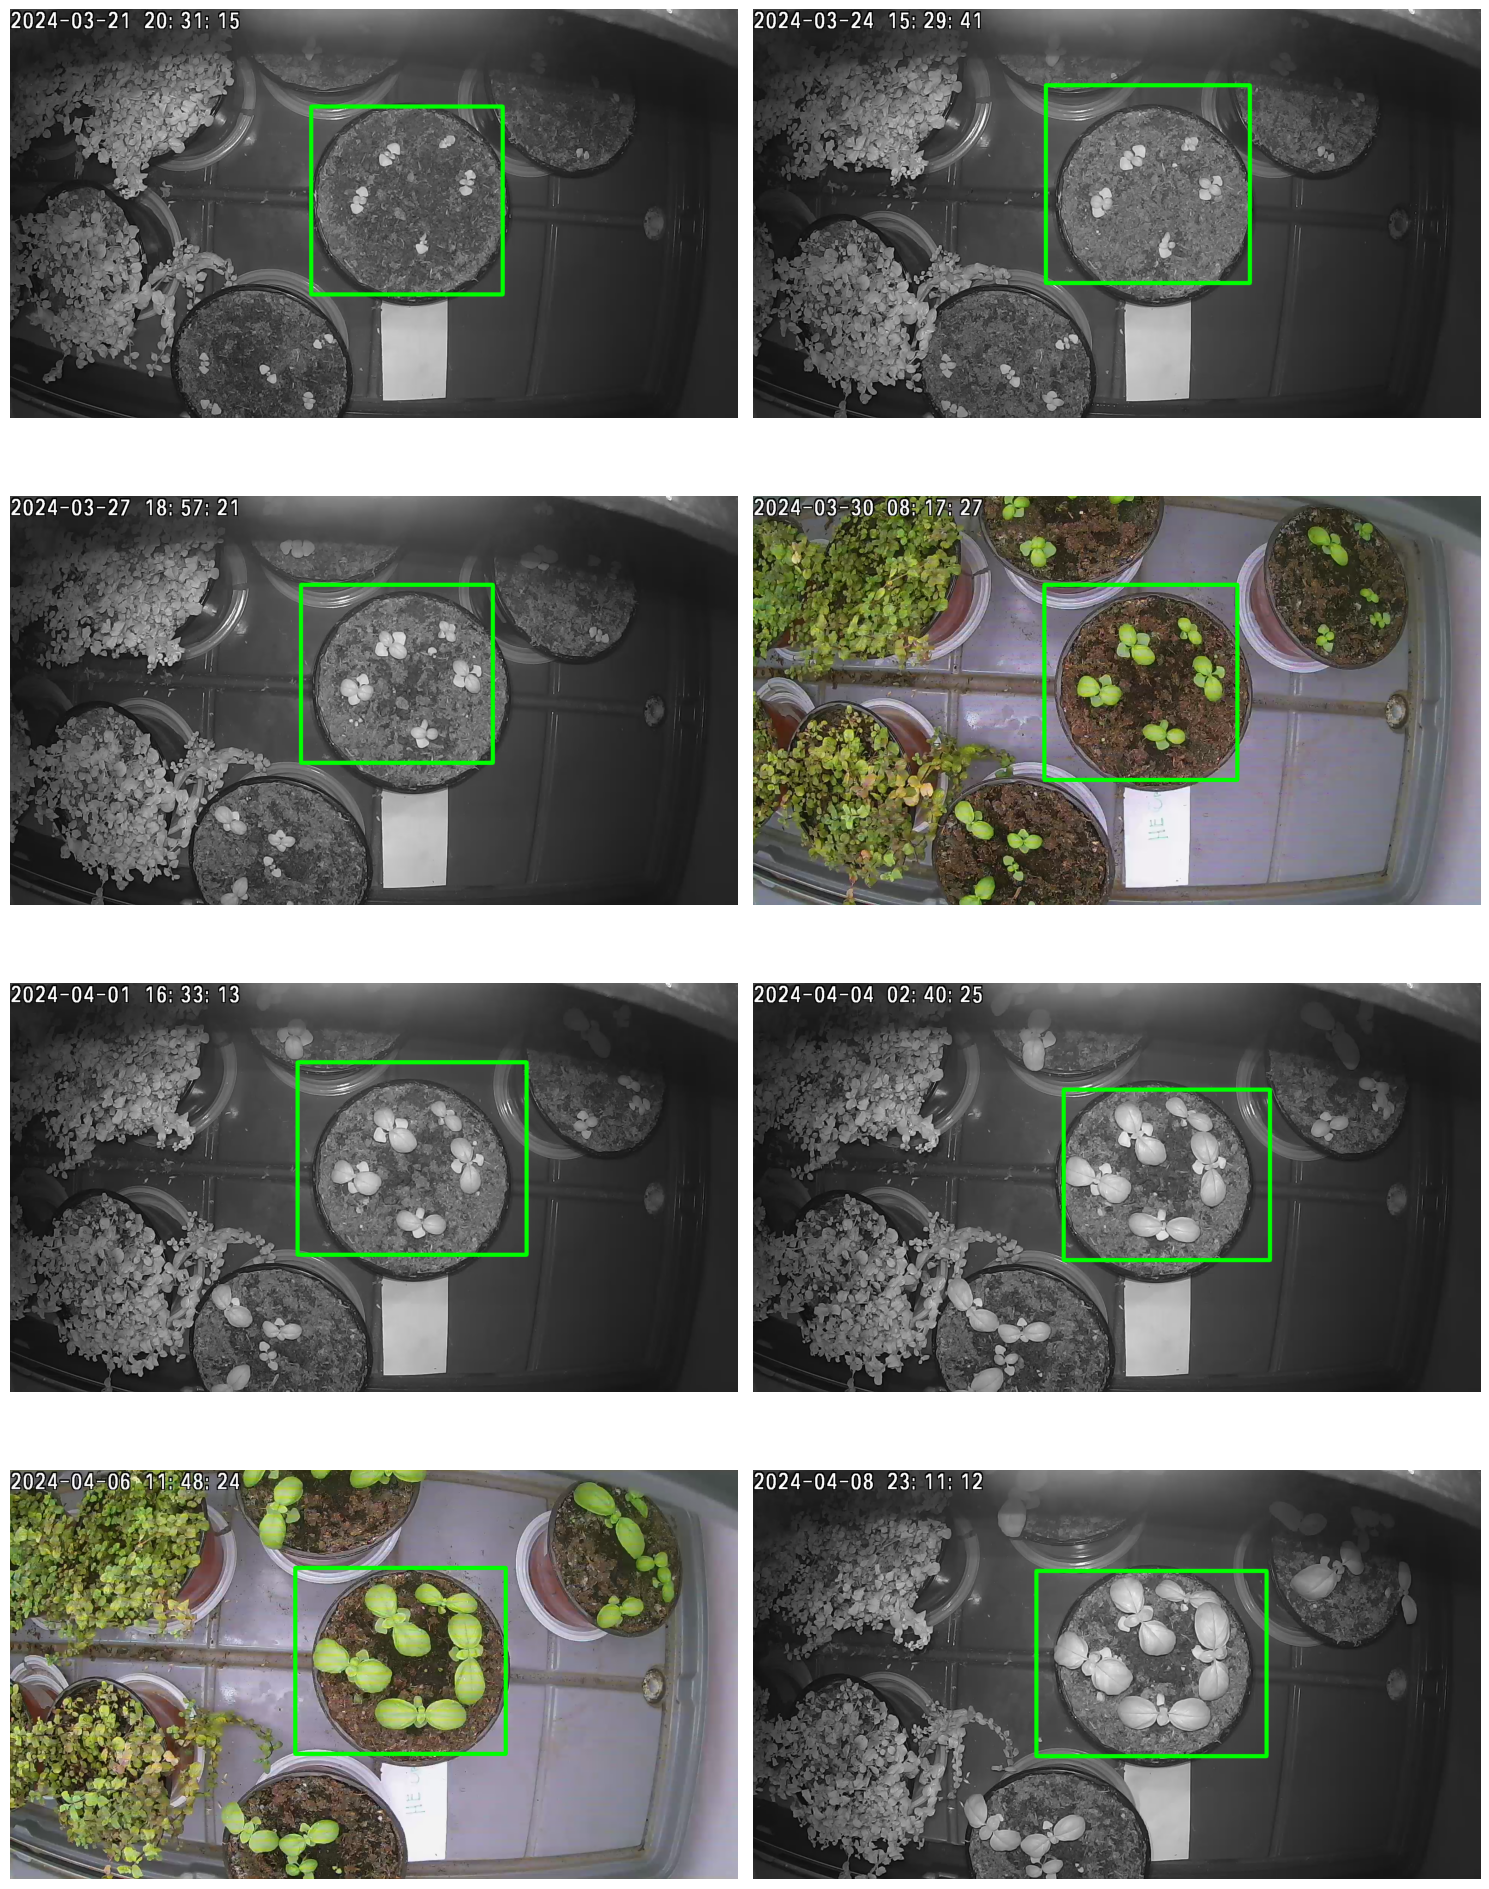

In [5]:
exp = "exp20240321"
# cam = "CAM_2_3" # train
cam = "CAM_1_3" # train
data_path = Path("/Volumes/Black/Data")/exp/cam
dates_paths = [date for date in list(data_path.iterdir()) if is_valid_date(str(date.name))]

images_paths = []
for date_path in dates_paths:
    images_date_paths = [image_path for image_path in list((date_path/"original").iterdir()) if image_path.name.endswith("png") and not image_path.name.startswith("._")]
    for image_path in images_date_paths:
        images_paths.append(image_path)


images_nums_for_visualize = np.linspace(0, len(images_paths)-1, 8).astype(int).tolist()
# x1, y1, x2, y2 = 580, 180, 1140, 720 # CAM_2_3
x1, y1, x2, y2 = 780, 240, 1320, 750 # CAM_1_3
images = []
for i in images_nums_for_visualize:
    x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    # x1_rand, y1_rand, x2_rand, y2_rand = x1, y1, x2, y2
    image_path = images_paths[i]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_rect = cv2.rectangle(image_rgb.copy(), (x1, y1), (x2, y2), (0,255,0), 10)
    image_rect = cv2.rectangle(image_rgb.copy(), (x1_rand, y1_rand), (x2_rand, y2_rand), (0,255,0), 10)
    images.append(image_rect)
    
display_images_side_by_side(images, max_images_per_row=2)    

In [6]:
dataset_name = "instance_segmentation_basil"
dataset_path = Path("./../datasets") / dataset_name 
print(dataset_path.exists())

True


In [105]:
train_dataset_len = 20
images_nums_for_visualize = np.linspace(0, len(images_paths)-1, train_dataset_len).astype(int).tolist()
# x1, y1, x2, y2 = 580, 180, 1140, 720 # уже есть выше
images = []
for i in images_nums_for_visualize:
    x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    image_path = images_paths[i]
    image = cv2.imread(image_path)
    # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image[y1_rand:y2_rand, x1_rand:x2_rand]
    new_image_path = dataset_path / "images" /image_path.name
    cv2.imwrite(str(new_image_path), image)
    
# display_images_side_by_side(images, max_images_per_row=2)    

### Создаем тестовый датасет на 3 камерах

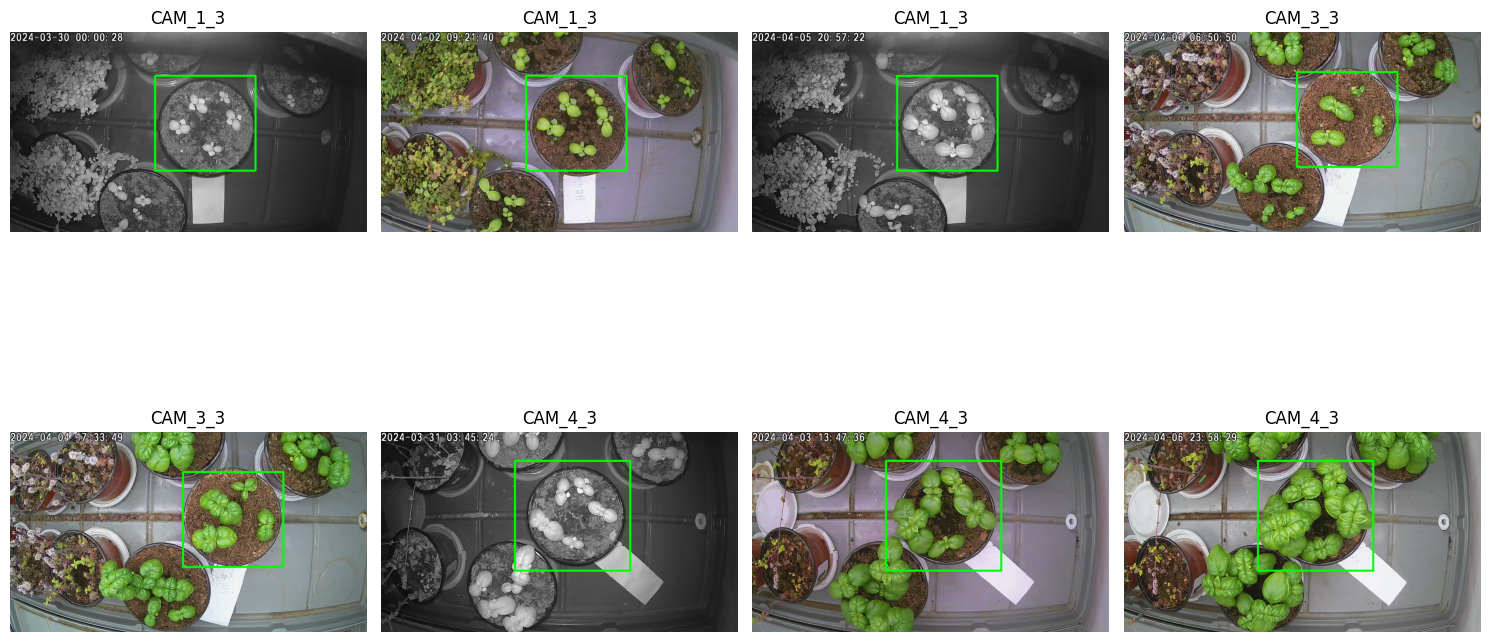

In [13]:
exp = "exp20240321"
test_cams = ["CAM_1_3", "CAM_3_3", "CAM_4_3"]

exp_path = Path("/Volumes/Black/Data")/exp
images_paths = []

for cam in test_cams:
    dates_paths = [date for date in list((exp_path/cam).iterdir()) if is_valid_date(str(date.name))]
    for date_path in dates_paths[(len(dates_paths)//2):-2]: # берем только втору половину, чтобы расширить датасет большими растениями
        images_date_paths = [image_path for image_path in list((date_path/"original").iterdir()) if image_path.name.endswith("png") and not image_path.name.startswith("._")]
        images_paths += images_date_paths


images_nums_for_visualize = np.linspace(0, len(images_paths)-1, 8).astype(int).tolist()
crop_values = {
    "CAM_1_3" : {
        "x1" : 780,
        "y1" : 240,
        "x2" : 1320,
        "y2" : 750
    },
    "CAM_3_3" : {
        "x1" : 930,
        "y1" : 220,
        "x2" : 1470,
        "y2" : 730
    },
    "CAM_4_3" : {
        "x1" : 720,
        "y1" : 160,
        "x2" : 1340,
        "y2" : 750
    },
}
images = []
images_names = []
for i in images_nums_for_visualize[:10]:
# for i in images_nums_for_visualize:
    image_path = images_paths[i]
    image_cam = image_path.parent.parent.parent.name
    x1, y1, x2, y2 = crop_values[image_cam]["x1"], crop_values[image_cam]["y1"], crop_values[image_cam]["x2"], crop_values[image_cam]["y2"]
    # x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    x1_rand, y1_rand, x2_rand, y2_rand = x1, y1, x2, y2
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_rect = cv2.rectangle(image_rgb.copy(), (x1, y1), (x2, y2), (0,255,0), 10)
    image_rect = cv2.rectangle(image_rgb.copy(), (x1_rand, y1_rand), (x2_rand, y2_rand), (0,255,0), 10)
    images.append(image_rect)
    images_names.append(image_cam)
    
display_images_side_by_side(images, titles=images_names, max_images_per_row=4)    

In [14]:
images = []
images_names = []
# for i in images_nums_for_visualize[10:13]:
images_nums_for_save = np.linspace(0, len(images_paths)-1, 50).astype(int).tolist()
for i in images_nums_for_save:
    image_path = images_paths[i]
    image_cam = image_path.parent.parent.parent.name
    x1, y1, x2, y2 = crop_values[image_cam]["x1"], crop_values[image_cam]["y1"], crop_values[image_cam]["x2"], crop_values[image_cam]["y2"]
    x1_rand, y1_rand, x2_rand, y2_rand = randomize_crop_coords(x1, y1, x2, y2, num=50)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rect = cv2.rectangle(image_rgb.copy(), (x1_rand, y1_rand), (x2_rand, y2_rand), (0,255,0), 10)

    image = image[y1_rand:y2_rand, x1_rand:x2_rand]
    new_image_name = exp + "_" + image_cam + "_" + image_path.name
    # new_image_path = dataset_path / "test" / "images" / new_image_name
    new_image_path = dataset_path / "train2" / "images" / new_image_name
    # print(new_image_path)
    # raise KeyboardInterrupt
    cv2.imwrite(str(new_image_path), image)